### Importing Libraries

In [147]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as TF

In [148]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Building Dataset as a pair noisy and clean 

In [150]:
# Custom Dataset Class for Document Denoising
class DocumentDenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        
        # Get file names (assuming matching names in both directories)
        self.filenames = [f for f in os.listdir(noisy_dir) if f.endswith(('.png', '.jpg', '.tif'))]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # Load images
        noisy_path = os.path.join(self.noisy_dir, self.filenames[idx])
        clean_path = os.path.join(self.clean_dir, self.filenames[idx])
        
        noisy_image = Image.open(noisy_path).convert('L')  # Convert to grayscale
        clean_image = Image.open(clean_path).convert('L')
        
        # Apply transforms if any
        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)
        else:
            # Default transformation
            noisy_image = TF.to_tensor(noisy_image)
            clean_image = TF.to_tensor(clean_image)
            
        return noisy_image, clean_image


### Build a Autoencoder Model

In [151]:
# Define the Convolutional Autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # Downsample by factor of 2
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # Downsample by factor of 2
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)   # Downsample by factor of 2
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Train function of model 

In [164]:
import time

def train_model(model, train_loader, valid_loder, criterion, optimizer, num_epochs=10):
    train_losses = []
    valid_losses = []
    times = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for noisy_imgs, clean_imgs in train_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            
            # Forward pass
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        valid_loss = 0.0
        
        with torch.no_grad():
            for noisy_imgs, clean_imgs in valid_loder:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                outputs = model(noisy_imgs)
                loss = criterion(outputs, clean_imgs)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(valid_loder)
        valid_losses.append(valid_loss)
        
        # Record elapsed time
        current_time = time.time() - start_time
        times.append(current_time)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Time: {current_time:.2f}s')
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Time: {current_time:.2f}s')
    
    # return train_losses, test_losses = 0, times
    return train_losses, valid_losses, times

In [135]:
# Function to calculate MSE and SSIM for test samples
def evaluate_model(model, test_loader, criterion=nn.MSELoss()):
    model.eval()
    mse_scores = []
    ssim_scores = []
    test_images = []
    test_losses = []  # List to store individual batch losses
    total_test_loss = 0.0
    
    with torch.no_grad():
        for i, (noisy_imgs, clean_imgs) in enumerate(test_loader):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            
            # Get denoised images
            denoised_imgs = model(noisy_imgs)
            
            # Calculate batch loss
            loss = criterion(denoised_imgs, clean_imgs)
            total_test_loss += loss.item()
            test_losses.append(loss.item())  # Store the loss for this batch
            
            # Convert to numpy for evaluation metrics
            for j in range(noisy_imgs.size(0)):
                noisy_np = noisy_imgs[j].squeeze().cpu().numpy()
                clean_np = clean_imgs[j].squeeze().cpu().numpy()
                denoised_np = denoised_imgs[j].squeeze().cpu().numpy()
                
                # Calculate MSE
                mse = np.mean((clean_np - denoised_np) ** 2)
                mse_scores.append(mse)
                
                # Calculate SSIM
                ssim_score = ssim(clean_np, denoised_np, data_range=1.0)
                ssim_scores.append(ssim_score)
                
                # Store sample images for visualization
                if i == 0 and j < 5:  # Save first 5 test examples
                    test_images.append((noisy_np, clean_np, denoised_np))
    
    # Calculate average metrics
    avg_mse = np.mean(mse_scores)
    avg_ssim = np.mean(ssim_scores)
    avg_test_loss = total_test_loss / len(test_loader)
    
    # Print summary statistics
    print("\nTest Set Evaluation:")
    print(f"Average Test Loss: {avg_test_loss:.6f}")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average SSIM: {avg_ssim:.6f}")
    print(f"MSE Range: {min(mse_scores):.6f} to {max(mse_scores):.6f}")
    print(f"SSIM Range: {min(ssim_scores):.6f} to {max(ssim_scores):.6f}")
    print(f"Test Loses: {test_losses}")
    
    return mse_scores, ssim_scores, test_images, test_losses

In [158]:
# Plot training and validation losses
def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()



In [159]:
def plot_training_metrics(train_losses, valid_losses, times):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Training error vs. Time
    axes[0].plot(times, train_losses, 'b-', label='Training Error')
    axes[0].set_xlabel('Training Time (seconds)')
    axes[0].set_ylabel('Error (MSE)')
    axes[0].set_title('Training Error vs. Training Time')
    axes[0].grid(True)
    axes[0].legend()
    
    # Plot 2: Training and Testing error vs. Time
    axes[1].plot(times, train_losses, 'b-', label='Training Error')
    axes[1].plot(times, valid_losses, 'r-', label='Validation Error')
    axes[1].set_xlabel('Validation Time (seconds)')
    axes[1].set_ylabel('Error (MSE)')
    axes[1].set_title('Training and Validation Error vs. Training Time')
    axes[1].grid(True)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [160]:
# Define paths (you can modify these)
noisy_dir = "denoising_data/train/"
clean_dir = "denoising_data/train_cleaned/"
img_size = (256, 256)
val_size = 0.2 # of train
test_size = 0.2

# Define transformations
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

In [161]:
# Create full dataset
full_dataset = DocumentDenoisingDataset(noisy_dir, clean_dir, transform=transform)
print(full_dataset[0])

(tensor([[[0.9098, 0.9059, 0.8902,  ..., 0.9137, 0.9098, 0.9137],
         [0.8824, 0.8902, 0.8902,  ..., 0.9020, 0.9059, 0.9216],
         [0.8824, 0.8980, 0.8980,  ..., 0.9059, 0.8941, 0.9098],
         ...,
         [0.8588, 0.8588, 0.8706,  ..., 0.8863, 0.8863, 0.8784],
         [0.8549, 0.8667, 0.8941,  ..., 0.8980, 0.8784, 0.8706],
         [0.8941, 0.8863, 0.8980,  ..., 0.9176, 0.8118, 0.5608]]]), tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8941, 0.5882]]]))


### Dataset preparation

In [162]:
# Calculate split sizes
test_split = int(test_size * len(full_dataset))
remaining_size = len(full_dataset) - test_split
valid_split = int(val_size * remaining_size)  # Validation is % of remaining data after test split
train_split = remaining_size - valid_split

# Split into train, validation, and test sets
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, 
    [train_split, valid_split, test_split],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

### Model Initialization and running

In [166]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Initialize model
model = ConvAutoencoder().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model (using test set for validation in this simplified version)
# train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Train the model with time tracking
train_losses, valid_loss, times = train_model(model, train_loader, valid_loader,  criterion, optimizer, num_epochs=10)



Epoch [1/10], Train Loss: 0.1367, Valid Loss: 0.1028, Time: 2.65s
Epoch [2/10], Train Loss: 0.0714, Valid Loss: 0.0532, Time: 5.18s
Epoch [3/10], Train Loss: 0.0506, Valid Loss: 0.0528, Time: 9.60s
Epoch [4/10], Train Loss: 0.0510, Valid Loss: 0.0535, Time: 14.73s
Epoch [5/10], Train Loss: 0.0510, Valid Loss: 0.0533, Time: 20.39s
Epoch [6/10], Train Loss: 0.0511, Valid Loss: 0.0533, Time: 27.64s
Epoch [7/10], Train Loss: 0.0512, Valid Loss: 0.0533, Time: 36.49s
Epoch [8/10], Train Loss: 0.0509, Valid Loss: 0.0532, Time: 46.25s
Epoch [9/10], Train Loss: 0.0509, Valid Loss: 0.0530, Time: 54.46s
Epoch [10/10], Train Loss: 0.0509, Valid Loss: 0.0528, Time: 63.34s


In [168]:
# # Plot training curves
# plot_losses(train_losses, test_losses)

In [169]:
# Evaluate on test set
mse_scores, ssim_scores, test_images, test_losses = evaluate_model(model, test_loader)


Test Set Evaluation:
Average Test Loss: 0.053024
Average MSE: 0.053024
Average SSIM: 0.156820
MSE Range: 0.037229 to 0.074704
SSIM Range: 0.105862 to 0.208253
Test Loses: [0.05005605146288872, 0.05092517286539078, 0.06847523152828217, 0.04427530616521835, 0.039112724363803864, 0.05292666703462601, 0.07249962538480759, 0.053056761622428894, 0.053176313638687134, 0.03965269774198532, 0.06732865422964096, 0.06161641702055931, 0.07470370829105377, 0.05006899684667587, 0.04088500142097473, 0.048191238194704056, 0.05168551951646805, 0.046656545251607895, 0.06078130751848221, 0.05316375941038132, 0.03722921386361122, 0.05476660281419754, 0.06733335554599762, 0.052041299641132355, 0.06681303679943085, 0.038562074303627014, 0.05012523755431175, 0.03857436031103134]


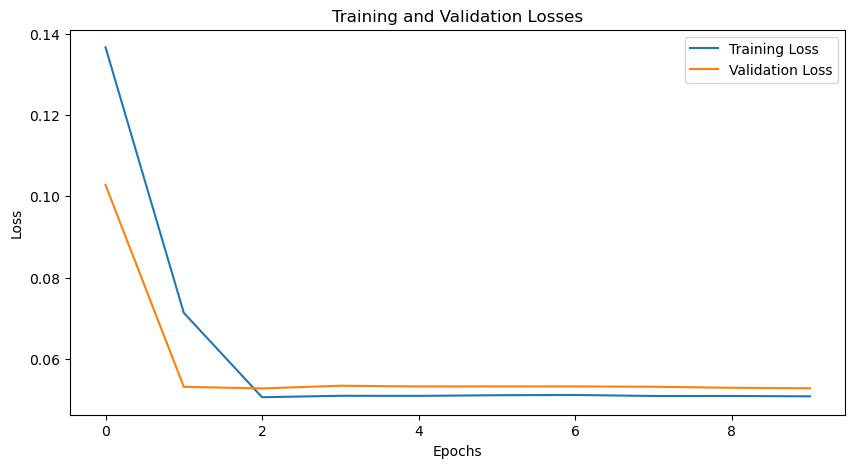

In [170]:
# Plot training curves
plot_losses(train_losses, valid_loss)

In [171]:
# Report detailed metrics for each test image
print("\nDetailed Test Results:")
print("----------------------")
for i, (mse, ssim_score) in enumerate(zip(mse_scores, ssim_scores)):
    print(f"Image {i+1}: MSE = {mse:.6f}, SSIM = {ssim_score:.6f}")




Detailed Test Results:
----------------------
Image 1: MSE = 0.050056, SSIM = 0.208253
Image 2: MSE = 0.050925, SSIM = 0.177843
Image 3: MSE = 0.068475, SSIM = 0.169232
Image 4: MSE = 0.044275, SSIM = 0.174743
Image 5: MSE = 0.039113, SSIM = 0.162867
Image 6: MSE = 0.052927, SSIM = 0.178258
Image 7: MSE = 0.072500, SSIM = 0.170422
Image 8: MSE = 0.053057, SSIM = 0.145119
Image 9: MSE = 0.053176, SSIM = 0.143805
Image 10: MSE = 0.039653, SSIM = 0.121969
Image 11: MSE = 0.067329, SSIM = 0.110059
Image 12: MSE = 0.061616, SSIM = 0.105862
Image 13: MSE = 0.074704, SSIM = 0.162582
Image 14: MSE = 0.050069, SSIM = 0.197278
Image 15: MSE = 0.040885, SSIM = 0.163920
Image 16: MSE = 0.048191, SSIM = 0.179209
Image 17: MSE = 0.051686, SSIM = 0.185856
Image 18: MSE = 0.046657, SSIM = 0.186162
Image 19: MSE = 0.060781, SSIM = 0.118984
Image 20: MSE = 0.053164, SSIM = 0.140747
Image 21: MSE = 0.037229, SSIM = 0.180173
Image 22: MSE = 0.054767, SSIM = 0.146156
Image 23: MSE = 0.067333, SSIM = 0.109

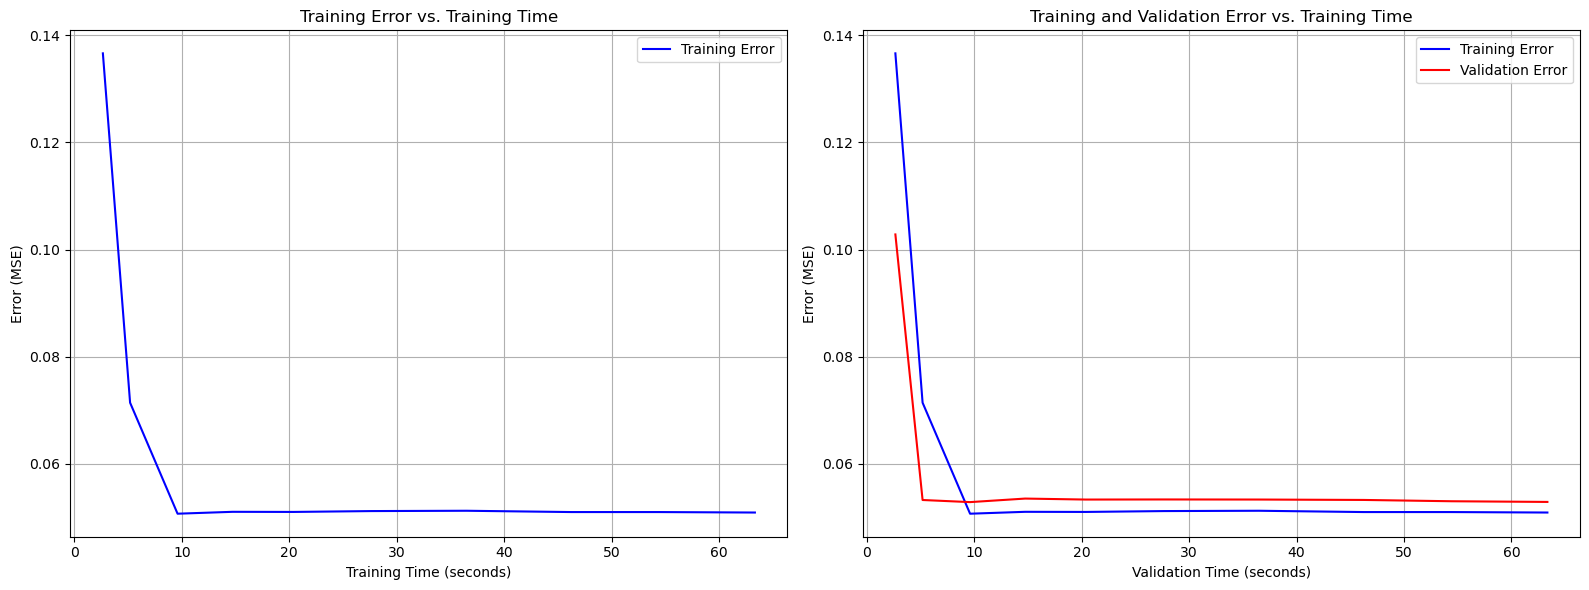

In [173]:
# Plot new time-based metrics
plot_training_metrics(train_losses, valid_loss, times)


In [174]:
def visualize_results(test_images):
    n_images = len(test_images)
    fig, axes = plt.subplots(n_images, 3, figsize=(12, 4*n_images))
    
    # Handle case when there's only one test image
    if n_images == 1:
        axes = axes.reshape(1, 3)
    
    for i, (noisy, clean, denoised) in enumerate(test_images):
        # Display noisy image
        axes[i, 0].imshow(noisy, cmap='gray')
        axes[i, 0].set_title('Noisy Image')
        axes[i, 0].axis('off')
        
        # Display ground truth
        axes[i, 1].imshow(clean, cmap='gray')
        axes[i, 1].set_title('Clean Image (Ground Truth)')
        axes[i, 1].axis('off')
        
        # Display denoised image
        axes[i, 2].imshow(denoised, cmap='gray')
        axes[i, 2].set_title(f'Denoised Image\nMSE: {np.mean((clean-denoised)**2):.6f}\nSSIM: {ssim(clean, denoised, data_range=1.0):.6f}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize results with fixed function
visualize_results(test_images)